In [1]:


%load_ext autoreload
%autoreload 2

from pyomo.environ import *
from optimization import TransitionModel
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import datetime as dt



In [2]:
file_path="../../processing/input/new_format/new_format-2020.xlsx"


df=pd.read_excel(file_path,sheet_name=None)

df["Demand"].columns=df["Demand"].columns.map(lambda x: x.replace(" (MWh)",""))
df["SupIm"].columns=df["SupIm"].columns.map(lambda x: x.replace(" (m/s)","").replace(" (kJ/m2)",""))

In [3]:





model = TransitionModel(df)
model, results = model.optimize()


    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.11.1\x3a Converged to a locally
        infeasible point. Problem may be infeasible.


In [4]:


all_dict={}

regions=list(model.Regions.data())
renewable_processes=["Solar","Wind"]

for region in regions :
    for proc in renewable_processes:
        all_dict[region+"-"+proc]=[]
        for t in range(len(model.Time)):
            all_dict[region+"-"+proc].append(model.region_fraction[(region, proc)].value*model.average_demand_region[(region)]*model.supim_capacity_factor_ratio[(t, region, proc)])


region="SouthEast"
# proc="Solar"
# t=1
# model.region_fraction[(region, proc)].value*model.average_demand_region[(region)]*model.supim_capacity_factor_ratio[(t, region, proc)]



In [5]:
lst = []
for k, v in dict(model.region_fraction).items():
    lst.append((k[0], k[1], v.value))

# pd.DataFrame(lst).to_excel(r'xx.xlsx')

In [6]:
ts_df=pd.DataFrame(all_dict,index=pd.date_range("1/1/2020", periods=8760,freq='1H')
)


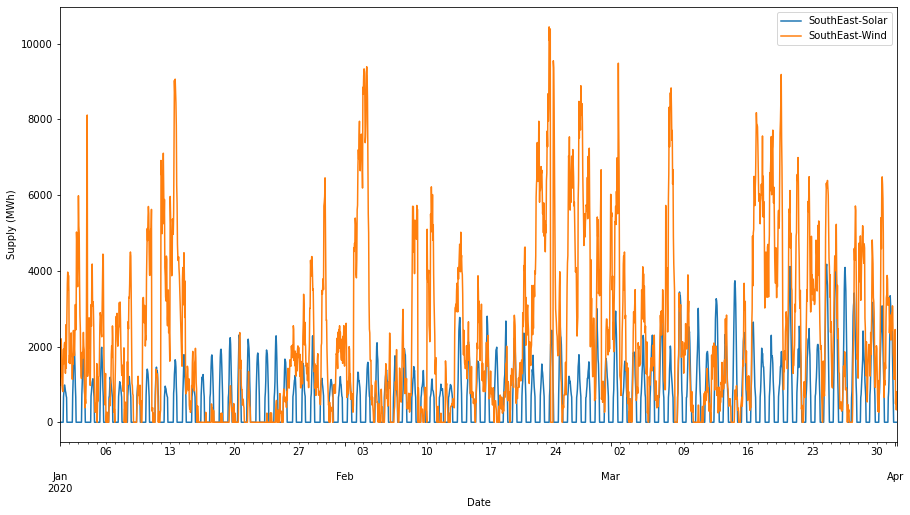

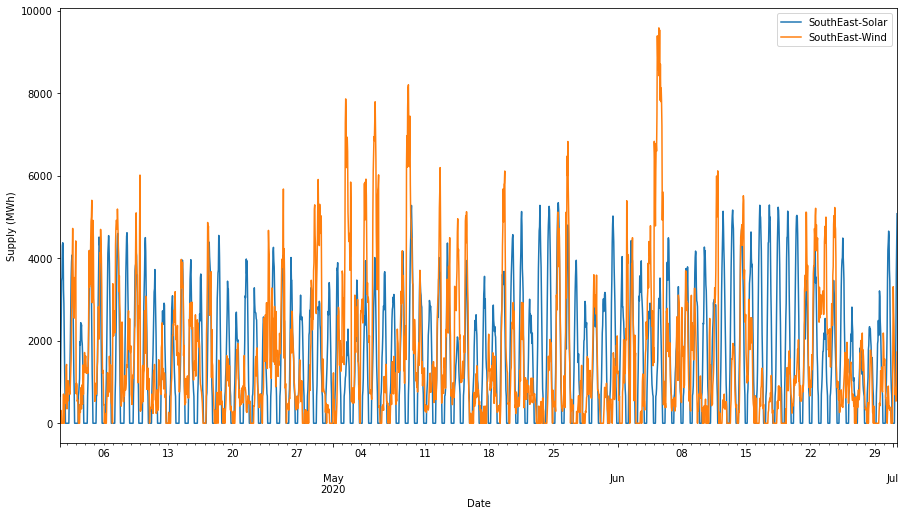

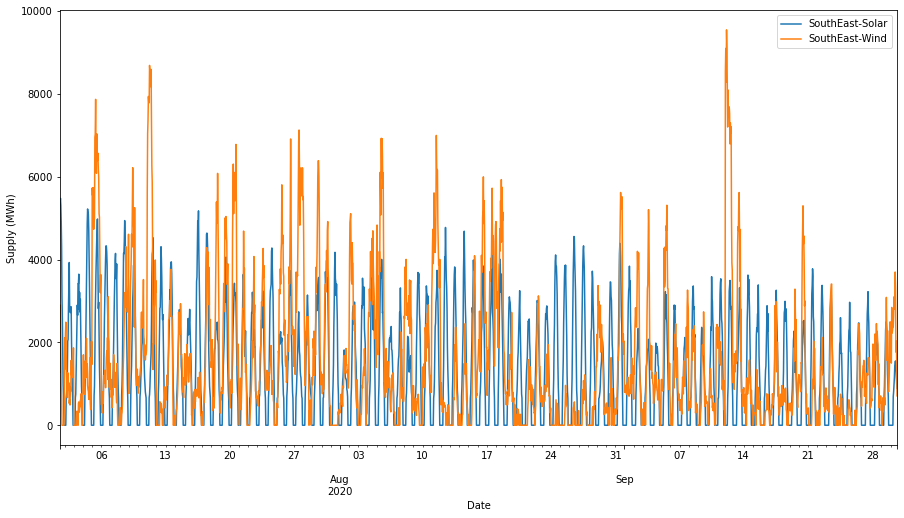

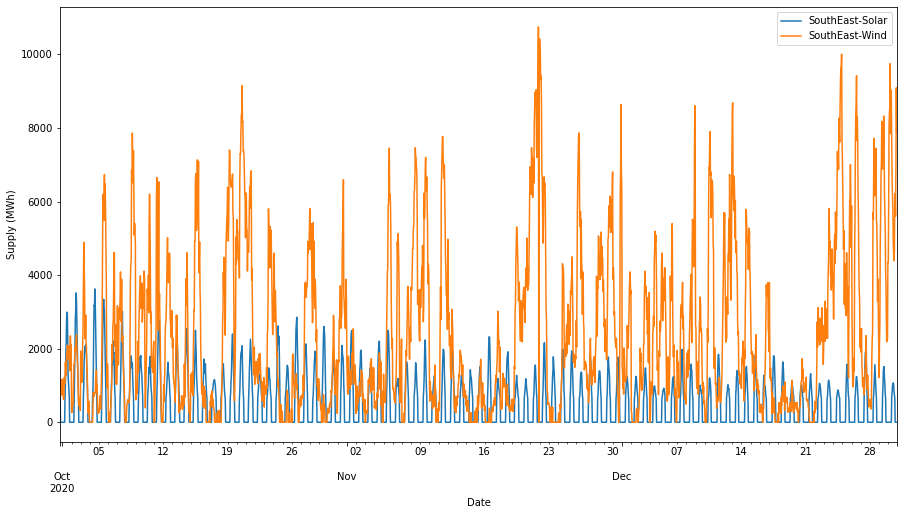

In [7]:

for i in range(2190,8760+2190,2190):
    fig, ax = plt.subplots(figsize = (15,8))

    ts_df[i-2190:i].plot( y = [region+"-Solar",region+"-Wind"], kind = 'line', ax = ax)
    plt.xlabel("Date")
    plt.ylabel("Supply (MWh)")
    plt.savefig('pics/'+region+'Supply-'+str(i)+'.png', bbox_inches='tight')



In [8]:

all_dict={}

regions=list(model.Regions.data())
# renewable_processes=["Solar","Wind"]
processes=list(model.Processes.data())

for region_ in regions :
    all_dict[region_]=[]
    for time in range(len(model.Time)):
        tot=0
        for process in processes:

            tot+=(model.average_demand_region[region_]*(model.region_fraction[region_, process].value * model.supim_capacity_factor_ratio[time,region_, process]))
            # all_dict[region+"-"+process].append((model.demand_region[time, region] - (model.average_demand_region[region]*(model.region_fraction[region, process].value * model.supim_capacity_factor_ratio[time,region, process]))

        all_dict[region_].append((model.demand_region[time, region_]-tot ))





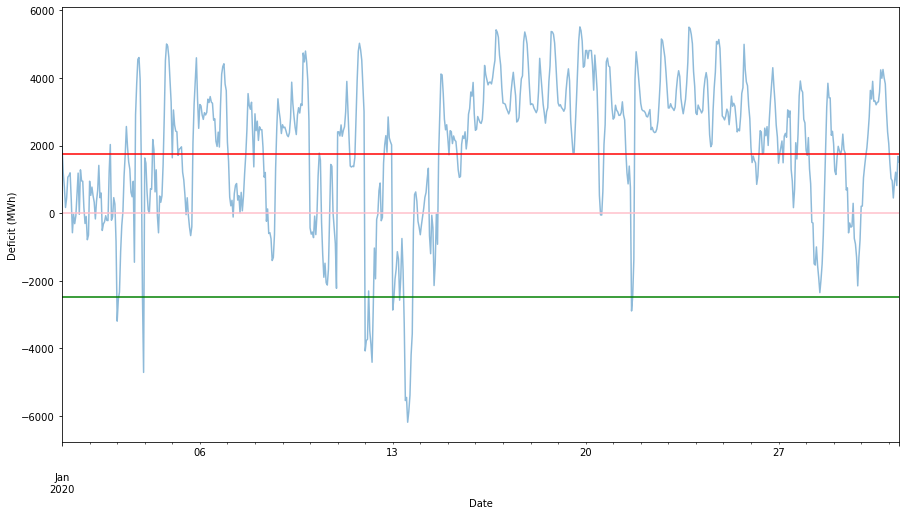

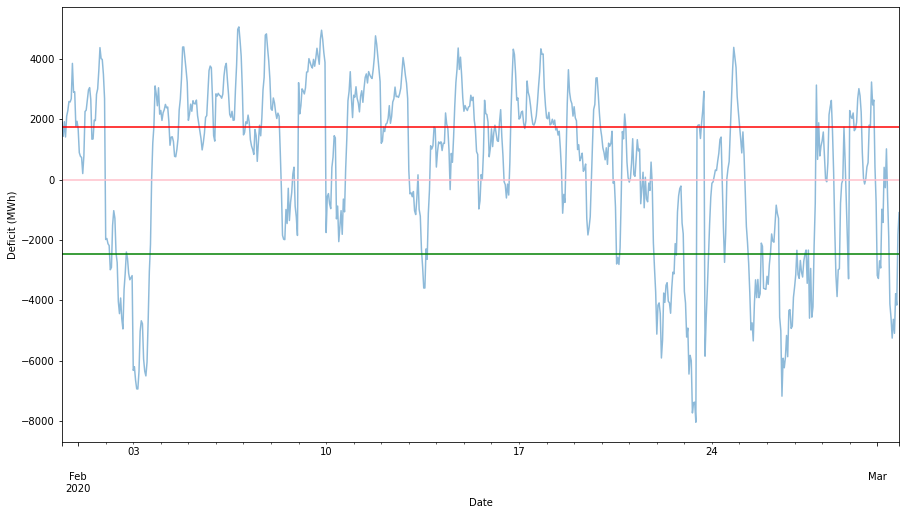

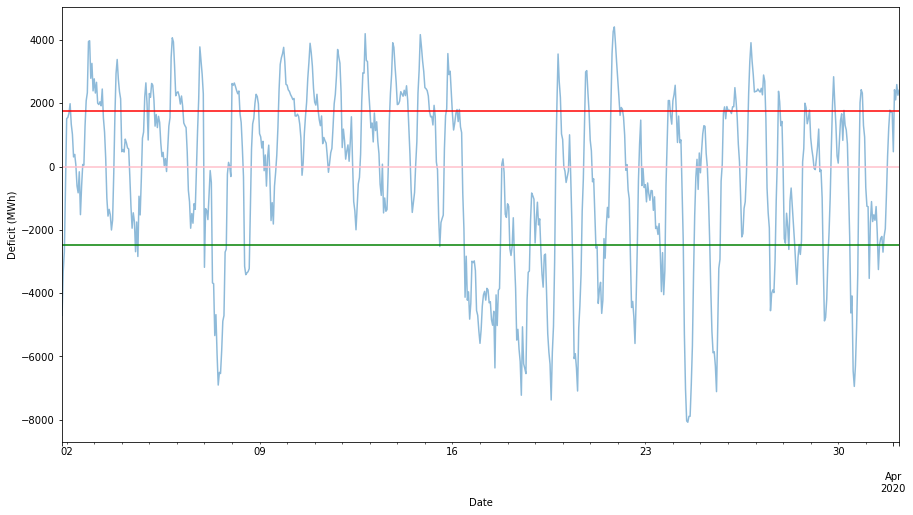

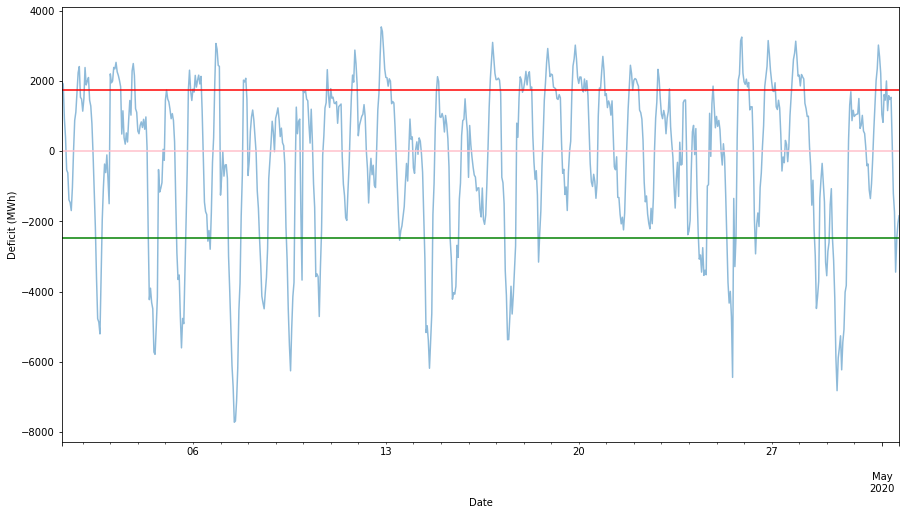

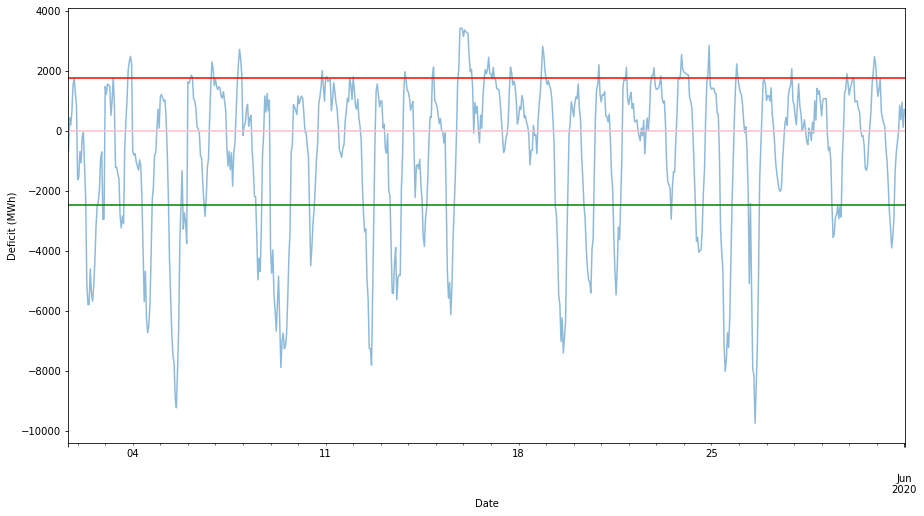

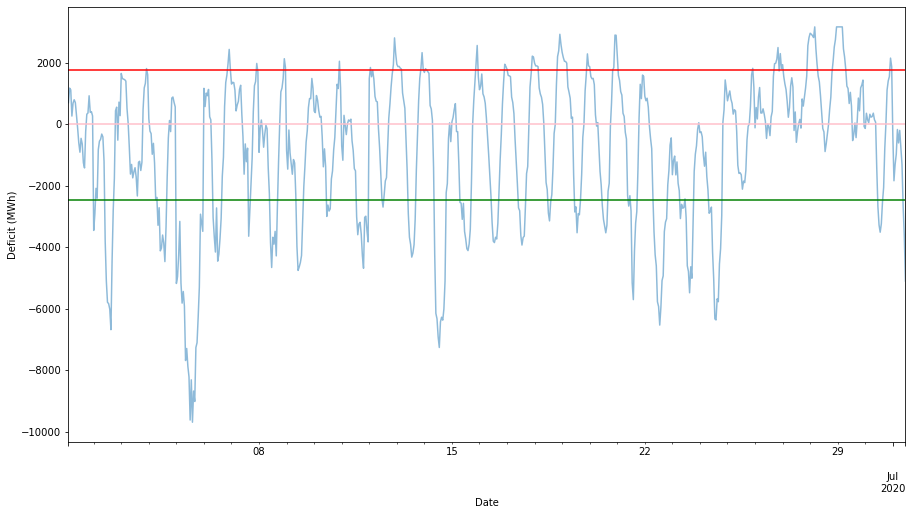

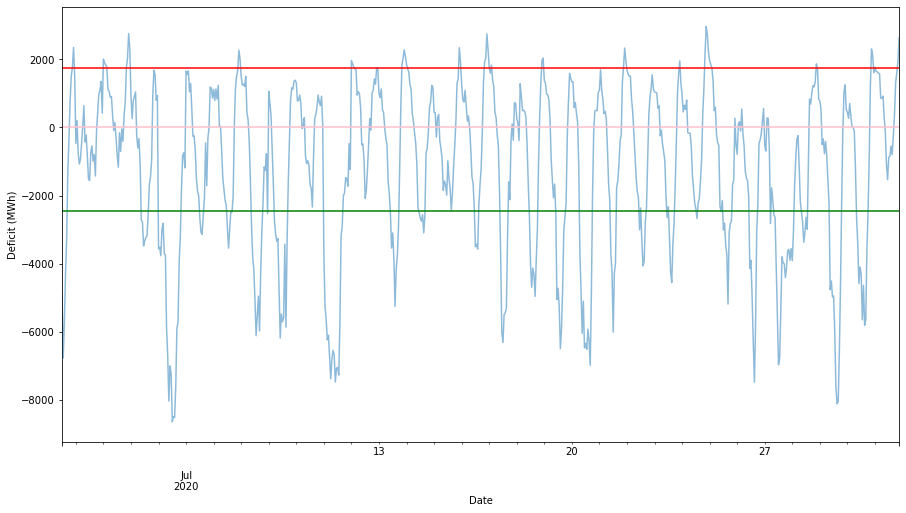

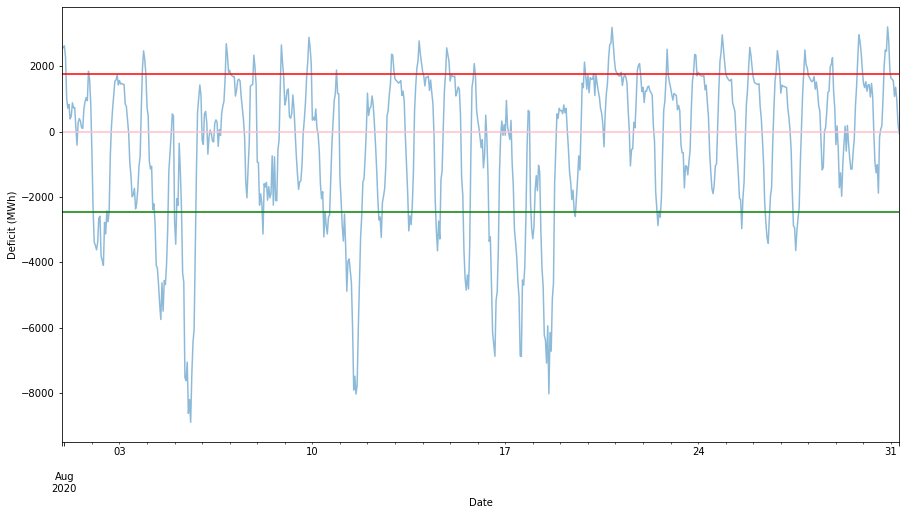

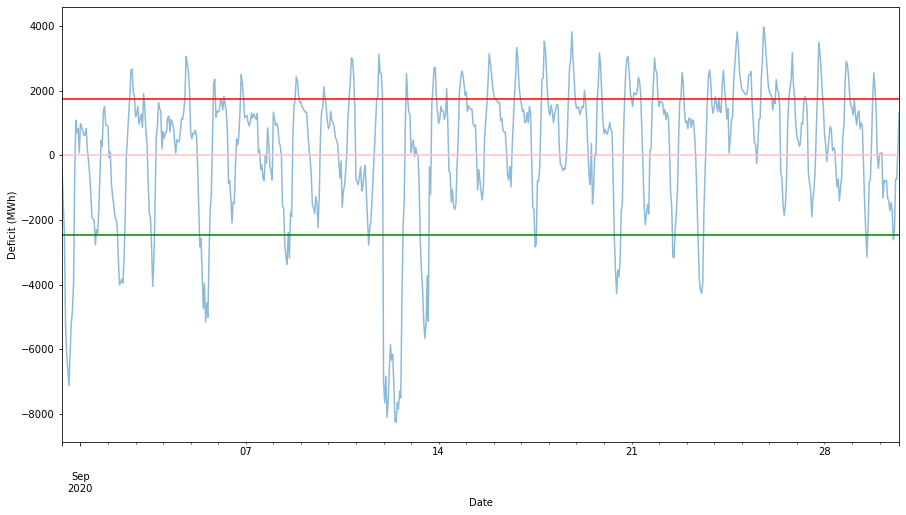

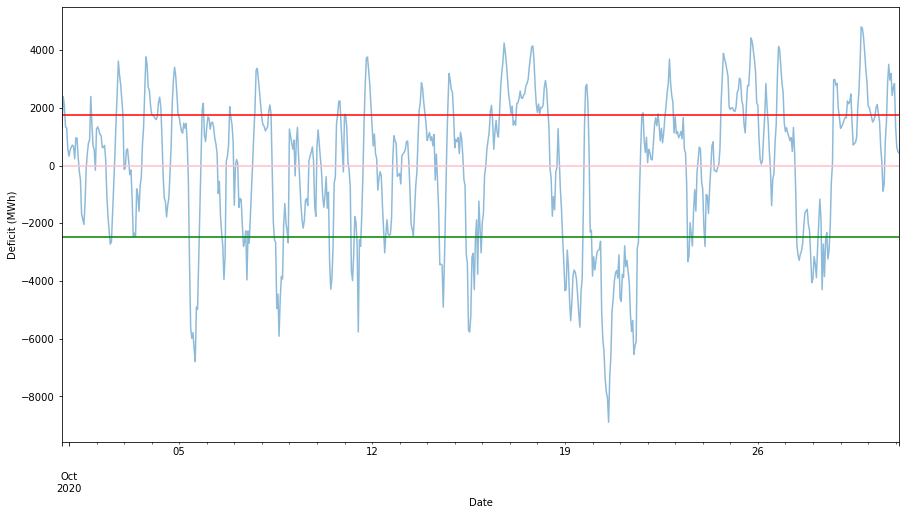

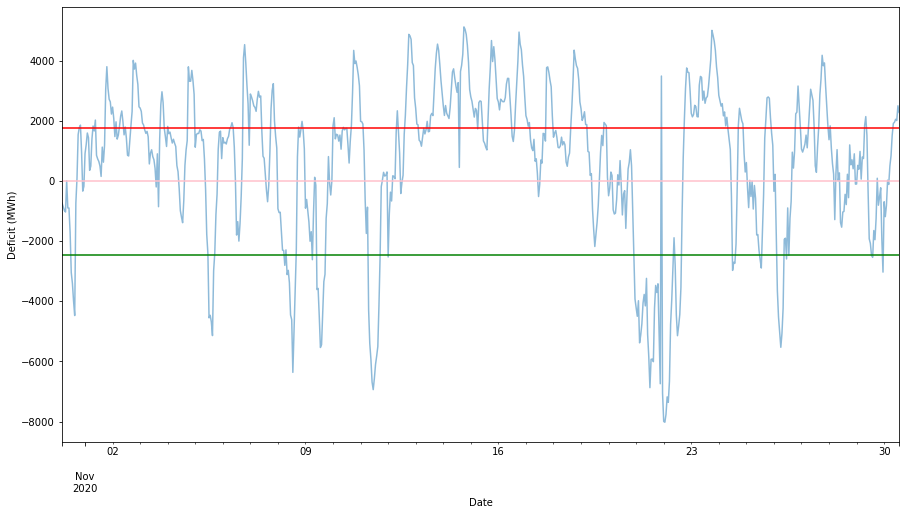

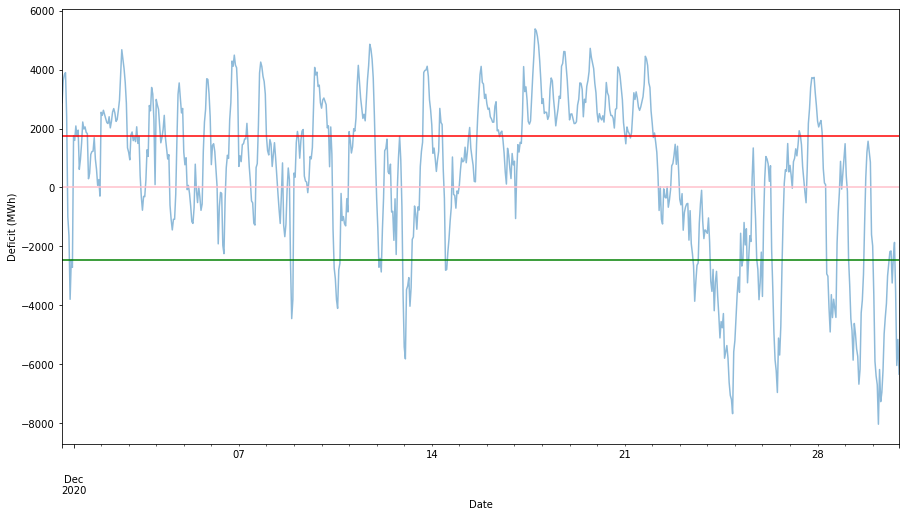

In [9]:
ts_df_dem=pd.DataFrame(all_dict,index=pd.date_range("1/1/2020", periods=8760,freq='1H')
)

merged = pd.concat([ts_df_dem[region][ts_df_dem[region]>=0], ts_df_dem[region][ts_df_dem[region]<0]], axis=1)
merged.columns=["positive","negative"]
merged["positive"].mean()
merged["negative"].mean()

cuts=12
step=int(8760/cuts)
for i in range(step,8760+step,step):
    fig, ax = plt.subplots(figsize = (15,8))

    ts_df_dem[region][i-step:i].plot(  kind = 'line', ax = ax,alpha=0.5)
    plt.axhline(y=merged["positive"].mean(), color='r', linestyle='-')
    plt.axhline(y=merged["negative"].mean(), color='g', linestyle='-')
    plt.axhline(y=ts_df_dem[region].mean(), color='pink', linestyle='-')
    plt.xlabel("Date")
    plt.ylabel("Deficit (MWh)")
    plt.savefig('pics/'+region+'Demand-'+str(i)+'.png', bbox_inches='tight')



In [10]:


ts_df_dem

,SouthWest,SouthEast,GreaterLondon
2020-01-01 00:00:00,1818.899634,1976.191683,-255.919338
2020-01-01 01:00:00,1249.722953,1192.945355,913.619608
2020-01-01 02:00:00,774.634660,771.932727,491.616809
2020-01-01 03:00:00,1089.560477,169.872588,862.842582
2020-01-01 04:00:00,880.918172,458.296569,775.355975
...,...,...,...
2020-12-30 19:00:00,-2819.953774,-1867.767554,-1138.938181
2020-12-30 20:00:00,-3153.797406,-3550.822089,-509.888233
2020-12-30 21:00:00,-2660.312619,-6045.367573,-3479.076265
2020-12-30 22:00:00,-2461.752809,-5162.919998,-7661.859552


array([3.78394746e-01      -0.j        , 4.34793312e+06 +663659.0263653j ,
       5.71604331e+05 -474077.30271328j, ...,
       8.28365200e+05+1390425.42594043j, 5.71604331e+05 +474077.30271328j,
       4.34793312e+06 -663659.0263653j ])

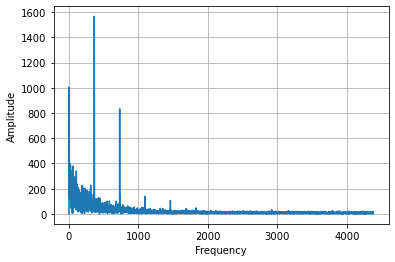

In [12]:
from scipy.fft import fft, fftfreq


a=(ts_df_dem[region]).to_numpy()
# Number of sample points
N = len((ts_df_dem[region]).to_numpy())
# sample spacing
T = 1.0 / N
yf = fft(a)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")    
plt.savefig('pics/'+region+'fourier-'+str(i)+'.png', bbox_inches='tight')

yf